In this Jupyter Notebook, all the six .nc datasets as well as the one .csv dataset are loaded and transformed into a pandas dataframe to be used as an X and y vector for a machine learning regressor (so far: XGBoost). The model (XGBoost) is trained using 5-fold Cross-Validation.

In [32]:
import pandas as pd
import xarray as xr
import numpy as np
from functools import reduce
from sklearn.model_selection import KFold
from sklearn.metrics import mean_pinball_loss
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
from lightgbm import LGBMRegressor
import seaborn as sns

In [33]:
import sys
print(sys.executable)  # Check which Python is running the kernel

/Users/lenakuhn/projects/project_A/.venv/bin/python


In this whole first part, the datasets are loaded and processed, dealing with missing values, dimensions, the time formatting etc.. The exact steps are explained using comments in the code snippets.

In [34]:
# Helper function for processing datasets
def process_dataset(ds, var_names, spatial_dims, prefix):
    dfs = []
    for var in var_names:
        if var in ds.variables:
            df = ds[var].mean(dim=spatial_dims).to_dataframe().reset_index()
            df.rename(columns={var: f"{prefix}_{var}"}, inplace=True)  # <--- rename columns here
            df["ref_datetime"] = df["ref_datetime"].dt.tz_localize("UTC")
            df["valid_datetime"] = df["ref_datetime"] + pd.to_timedelta(df["valid_datetime"], unit="hours")
            dfs.append(df)
    return dfs

In [35]:
# Load datasets
ds_list = [
    xr.open_dataset("dwd_icon_eu_hornsea_1_20200920_20231027.nc"),
    xr.open_dataset("dwd_icon_eu_pes10_20200920_20231027.nc"),
    xr.open_dataset("ncep_gfs_hornsea_1_20200920_20231027.nc"),
    xr.open_dataset("ncep_gfs_pes10_20200920_20231027.nc")
]

dataset_info = [
    ("pes_dwd", xr.open_dataset("dwd_icon_eu_pes10_20200920_20231027.nc")),
    ("hornsea_dwd", xr.open_dataset("dwd_icon_eu_hornsea_1_20200920_20231027.nc")),
    ("pes_ncep", xr.open_dataset("ncep_gfs_pes10_20200920_20231027.nc")),
    ("hornsea_ncep", xr.open_dataset("ncep_gfs_hornsea_1_20200920_20231027.nc"))
]

In [36]:
# Variables that are important
dwd_vars = ["RelativeHumidity", "Temperature", "WindDirection", "WindDirection:100", "WindSpeed", "WindSpeed:100", "CloudCover", "SolarDownwardRadiation"]
ncep_vars = ["RelativeHumidity", "Temperature", "WindDirection", "WindDirection:100", "WindSpeed", "WindSpeed:100", "CloudCover", "SolarDownwardRadiation"]

# Process each dataset individually
processed_dfs = []

In [37]:
# Process each dataset individually by:
# - Selecting the correct spatial dimensions (latitude/longitude or point)
# - Assigning the appropriate variable names (DWD or NCEP)
# - Adding a descriptive prefix (e.g., 'pes_dwd', 'hornsea_ncep') to each variable
# - Converting each variable into a DataFrame and appending it to the list of processed data
for prefix, ds in dataset_info:
    spatial_dims = ["latitude", "longitude"] if "latitude" in ds.dims else ["point"]
    var_names = dwd_vars if "dwd" in prefix else ncep_vars
    dfs = process_dataset(ds, var_names, spatial_dims, prefix)
    processed_dfs.extend(dfs)

In [38]:
# Merge all feature dataframes
modelling_table = reduce(lambda left, right: pd.merge(left, right, on=["ref_datetime", "valid_datetime"], how="outer"), processed_dfs)

In [39]:
# Load and process energy data
energy_data = pd.read_csv("Energy_Data_20200920_20231027.csv")
# Check if there are any missing values in the final dataframe
print(energy_data.isna().sum())

KeyboardInterrupt: 

In [ ]:
# Interpolation for the columns 'Solar_MW' und 'Wind_MW', since they have a couple of hundret missing datapoints
energy_data['Solar_MW'] = energy_data['Solar_MW'].interpolate(method='linear')
energy_data['Wind_MW'] = energy_data['Wind_MW'].interpolate(method='linear')
energy_data['boa_MWh'] = energy_data['boa_MWh'].interpolate(method='linear')

# Check if there's still missing values in the energy data dataframe
print(energy_data.isna().sum())

dtm                              0
MIP                            321
Solar_MW                         0
Solar_capacity_mwp               0
Solar_installedcapacity_mwp      0
Wind_MW                          0
SS_Price                         0
boa_MWh                          0
DA_Price                         0
dtype: int64


In [ ]:
energy_data["dtm"] = pd.to_datetime(energy_data["dtm"])
energy_data["Wind_MWh_credit"] = 0.5*energy_data["Wind_MW"] - energy_data["boa_MWh"]
energy_data["Solar_MWh_credit"] = 0.5*energy_data["Solar_MW"]
energy_data

# Select only the relevant columns
energy_data = energy_data[["dtm", "Solar_MW", "Solar_capacity_mwp", "Solar_installedcapacity_mwp", "Wind_MW", "Solar_MWh_credit", "Wind_MWh_credit"]]

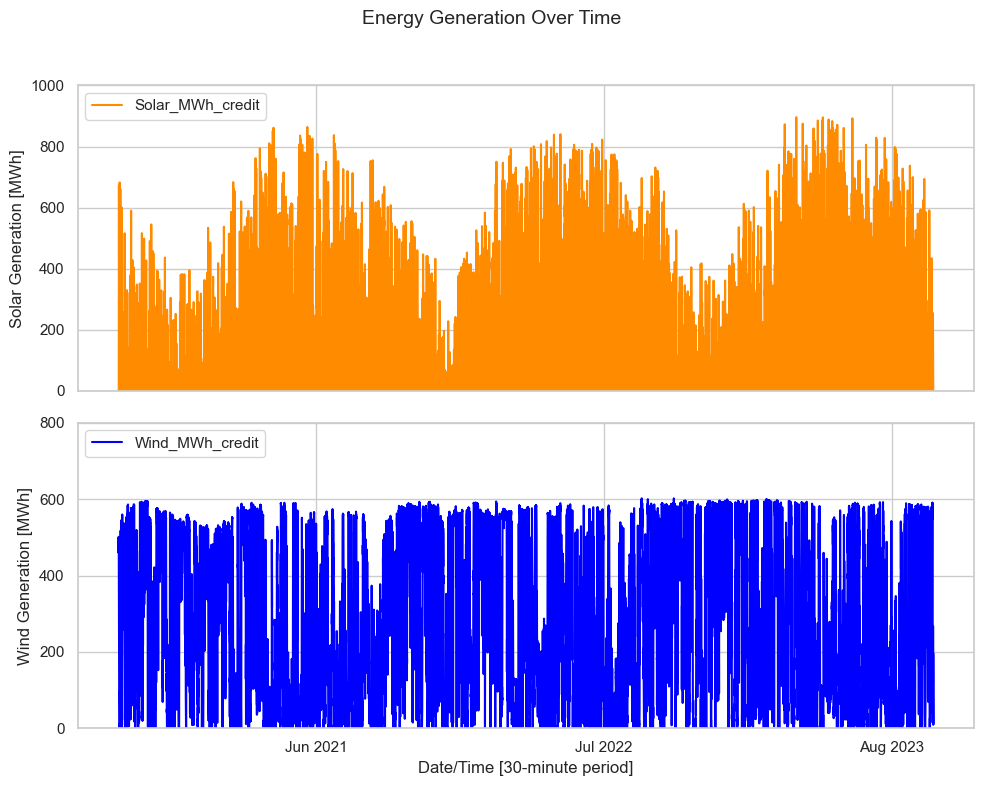

In [45]:
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator, MultipleLocator

sns.set(style='whitegrid')
sns.color_palette("pastel", as_cmap=True)

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Solar subplot
sns.lineplot(ax=axes[0], data=energy_data, x="dtm", y="Solar_MWh_credit", color="darkorange", label='Solar_MWh_credit')
axes[0].set_ylabel("Solar Generation [MWh]")
axes[0].legend(loc='upper left')
axes[0].xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
axes[0].xaxis.set_major_locator(MaxNLocator(nbins=4))
axes[0].set_ylim(0, 1000)
axes[0].set_xlabel("Date/Time [30-minute period]")  # label even though shared
axes[0].yaxis.set_major_locator(MultipleLocator(200))

# Wind subplot
sns.lineplot(ax=axes[1], data=energy_data, x="dtm", y="Wind_MWh_credit", color="blue", label='Wind_MWh_credit')
axes[1].set_ylabel("Wind Generation [MWh]")
axes[1].set_xlabel("Date/Time [30-minute period]")
axes[1].legend(loc='upper left')
axes[1].xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
axes[1].xaxis.set_major_locator(MaxNLocator(nbins=4))
axes[1].set_ylim(0, 800)
axes[1].yaxis.set_major_locator(MultipleLocator(200))

# Centered overall title
fig.suptitle("Energy Generation Over Time", ha='center', fontsize=14)

# Layout adjustment to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
# Continue processing
modelling_table = modelling_table.set_index("valid_datetime").groupby("ref_datetime").resample("30min").interpolate("linear")
modelling_table = modelling_table.drop(columns="ref_datetime", axis=1).reset_index()

# Merge with energy data
modelling_table = modelling_table.merge(energy_data, how="inner", left_on="valid_datetime", right_on="dtm")

# Filter for valid forecasts only (validity window)
modelling_table = modelling_table[modelling_table["valid_datetime"] - modelling_table["ref_datetime"] < np.timedelta64(50, "h")]

# If needed, rename variables to something cleaner
modelling_table.columns = [col.replace(":", "_") for col in modelling_table.columns]

In [ ]:
# Create temporal features from valid_datetime
modelling_table["hour"] = modelling_table["valid_datetime"].dt.hour
modelling_table["dayofweek"] = modelling_table["valid_datetime"].dt.dayofweek
modelling_table["month"] = modelling_table["valid_datetime"].dt.month

In [ ]:
# this code snippet is just for understanding how the ref_datetime and the valid_datetime work.
# So, as we can see, there is the ref_datetime 00:00:00+00:00 and at that point in time, a forecast ist made.
# The forecast is made AT ref_datetime FOR valid_datetime.

#------ YOU CAN UNCOMMENT THIS FOR YOUR UNDERSTANDING IF YOU WANT TO------
# print("modelling_table:")
# # Temporarily change display settings
# with pd.option_context('display.max_rows', 200, 'display.max_columns', 2):
#     print(modelling_table.iloc[:180, :2])

Now we have all the data in a huge dataframe. In this next part, a X and y vector is created, so that we can train an ml regressor oo that. So far we're doing this using LGBMRegressor and 5-fold cross validation.

In [ ]:
# Define common temporal features
common_time_features = ["hour", "dayofweek", "month"]

# For solar
solar_cols = (
    ["ref_datetime", "valid_datetime", "Solar_MWh_credit"] + 
    [col for col in modelling_table.columns if "pes_" in col] +
    common_time_features
)
mt_solar = modelling_table[solar_cols].copy()

# For wind
wind_cols = (
    ["ref_datetime", "valid_datetime", "Wind_MWh_credit"] + 
    [col for col in modelling_table.columns if "hornsea_" in col] +
    common_time_features
)
mt_wind = modelling_table[wind_cols].copy()

# Solar
X_solar = mt_solar.drop(columns=["ref_datetime", "valid_datetime", "Solar_MWh_credit"])
y_solar = mt_solar["Solar_MWh_credit"]

# Wind
X_wind = mt_wind.drop(columns=["ref_datetime", "valid_datetime", "Wind_MWh_credit"])
y_wind = mt_wind["Wind_MWh_credit"] 

# Create a mask for training and evaluation
cutoff_date = "2022-10-27"
train_mask = modelling_table["valid_datetime"] < cutoff_date
eval_mask = modelling_table["valid_datetime"] >= cutoff_date

# Split solar data
X_train_solar = X_solar[train_mask]
X_eval_solar = X_solar[eval_mask]
y_train_solar = y_solar[train_mask]
y_eval_solar = y_solar[eval_mask]

# Split wind data
X_train_wind = X_wind[train_mask]
X_eval_wind = X_wind[eval_mask]
y_train_wind = y_wind[train_mask]
y_eval_wind = y_wind[eval_mask]


#print("X_solar:")
print(X_solar.head(), "\n")
print(y_solar.head(), "\n")
print(X_wind.head(), "\n")
print(y_wind.head(), "\n")

   pes_dwd_Temperature  pes_dwd_CloudCover  pes_dwd_SolarDownwardRadiation  \
0            13.646173            0.450405                             0.0   
1            13.658508            0.472211                             0.0   
2            13.670843            0.494018                             0.0   
3            13.732101            0.520214                             0.0   
4            13.793360            0.546410                             0.0   

   pes_ncep_Temperature  pes_ncep_CloudCover  pes_ncep_SolarDownwardRadiation  \
0             13.940016               0.0260                              0.0   
1             13.896579               0.0390                              0.0   
2             13.853142               0.0520                              0.0   
3             13.847113               0.0385                              0.0   
4             13.841084               0.0250                              0.0   

   hour  dayofweek  month  
0     0         

In [ ]:
# ------YOU CAN UNCOMMENT THIS TO SEE HOW THE DATAFRAMES LOOK LIKE--------

# print("X_train_solar:")
# print(X_train_solar.head(), "\n")

# print("X_eval_solar:")
# print(X_eval_solar.head(), "\n")

# print("y_train_solar:")
# print(y_train_solar.head(), "\n")

# print("y_eval_solar:")
# print(y_eval_solar.head(), "\n")

# print("X_train_wind:")
# print(X_train_wind.head(), "\n")

# print("X_eval_wind:")
# print(X_eval_wind.head(), "\n")

# print("y_train_wind:")
# print(y_train_wind.head(), "\n")

# print("y_eval_wind:")
# print(y_eval_wind.head(), "\n")


What happens in the following section?
Performing 5-fold cross-validation with LightGBM quantile regression for solar and wind energy generation data, across multiple quantiles. Computing pinball loss and normalizing it relative to the target.

In [ ]:
# Define quantiles to predict
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Function to run quantile regression with LGBM
def quantile_cv(X, y, label="MODEL"):
    print(f"\n===== {label.upper()} =====")
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    quantile_losses = {q: [] for q in quantiles}

    for train_idx, val_idx in kf.split(X):
        # Uses the split indices to pull the actual rows from X and y.
        # iloc is needed because train_idx and val_idx are numpy arrays of indices.
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
        
        for q in quantiles:
            model = LGBMRegressor(objective='quantile', alpha=q, random_state=42, verbosity=-1)
            model.fit(X_train_fold, y_train_fold)
            y_pred = model.predict(X_val_fold)
            loss = mean_pinball_loss(y_val_fold, y_pred, alpha=q)
            quantile_losses[q].append(loss)

    # Aggregate results
    print("Average Pinball Loss per Quantile:")
    for q in quantiles:
        avg_loss = np.mean(quantile_losses[q])
        print(f"  Quantile {int(q*100)}%: {avg_loss:.4f}")

    # Optional: Average over all quantiles
    avg_total_pinball_loss = np.mean([np.mean(losses) for losses in quantile_losses.values()])
    print(f"Average Pinball Loss (All Quantiles): {avg_total_pinball_loss:.4f}")

    normalized_pinball = avg_total_pinball_loss / y.mean()
    print(f"Normalized Pinball Loss: {normalized_pinball:.2%}")



# Run for Solar and Wind
quantile_cv(X_train_solar, y_train_solar, label="Solar")
quantile_cv(X_train_wind, y_train_wind, label="Wind")



===== SOLAR =====
Average Pinball Loss per Quantile:
  Quantile 10%: 5.2629
  Quantile 20%: 8.0089
  Quantile 30%: 9.6414
  Quantile 40%: 10.7147
  Quantile 50%: 10.9966
  Quantile 60%: 10.5819
  Quantile 70%: 9.4898
  Quantile 80%: 7.6472
  Quantile 90%: 4.8222
Average Pinball Loss (All Quantiles): 8.5739
Normalized Pinball Loss: 7.39%

===== WIND =====
Average Pinball Loss per Quantile:
  Quantile 10%: 11.5240
  Quantile 20%: 16.6878
  Quantile 30%: 20.2006
  Quantile 40%: 22.0762
  Quantile 50%: 22.6173
  Quantile 60%: 21.8047
  Quantile 70%: 19.5210
  Quantile 80%: 15.6941
  Quantile 90%: 10.0420
Average Pinball Loss (All Quantiles): 17.7964
Normalized Pinball Loss: 6.30%



===== Solar Quantile Pinball Loss =====
Quantile 10% Pinball Loss: 6.1096
Quantile 20% Pinball Loss: 9.3874
Quantile 30% Pinball Loss: 11.3839
Quantile 40% Pinball Loss: 12.3810
Quantile 50% Pinball Loss: 12.7025
Quantile 60% Pinball Loss: 12.2867
Quantile 70% Pinball Loss: 11.0878
Quantile 80% Pinball Loss: 9.0996
Quantile 90% Pinball Loss: 6.0474
Average Pinball Loss (All Quantiles): 10.0540
Normalized Pinball Loss: 8.16%


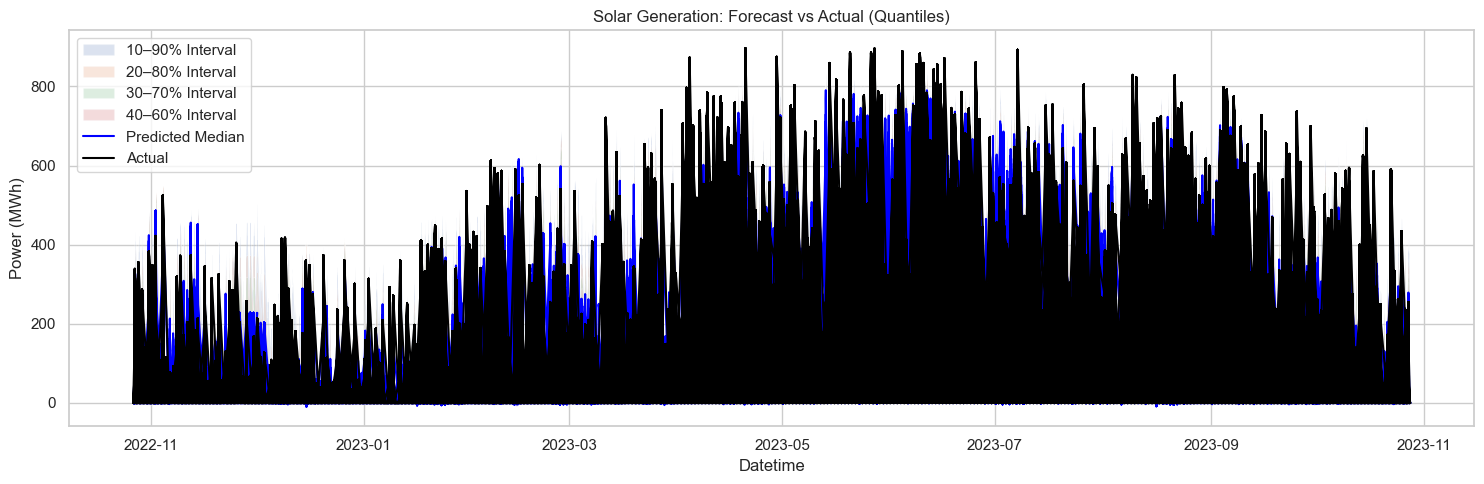

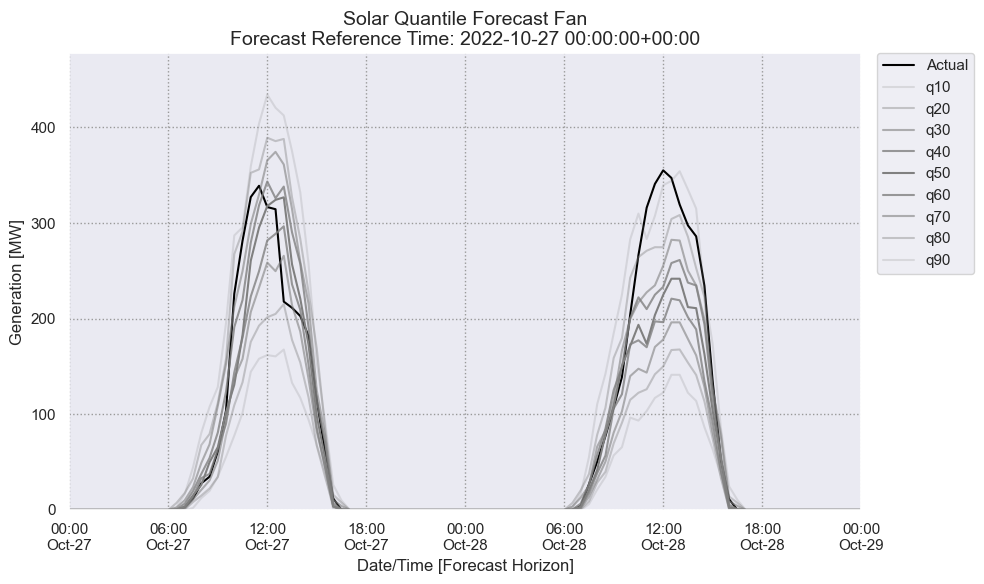


===== Wind Quantile Pinball Loss =====
Quantile 10% Pinball Loss: 14.7762
Quantile 20% Pinball Loss: 22.0389
Quantile 30% Pinball Loss: 27.1599
Quantile 40% Pinball Loss: 29.9687
Quantile 50% Pinball Loss: 30.8985
Quantile 60% Pinball Loss: 29.9387
Quantile 70% Pinball Loss: 26.9381
Quantile 80% Pinball Loss: 22.1419
Quantile 90% Pinball Loss: 14.7502
Average Pinball Loss (All Quantiles): 24.2901
Normalized Pinball Loss: 8.56%


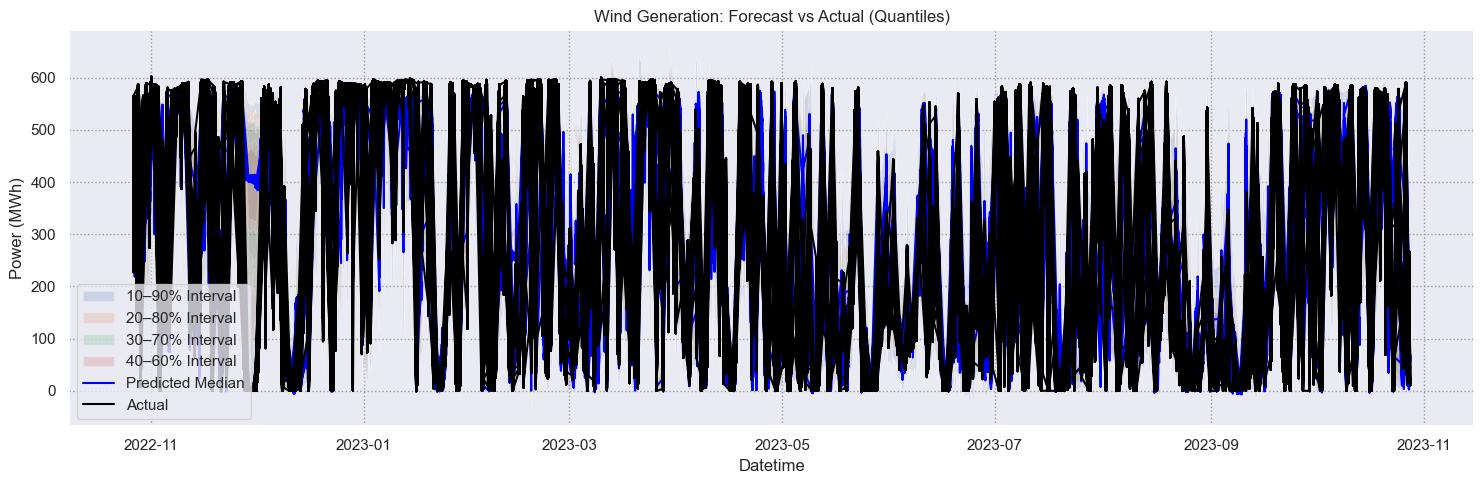

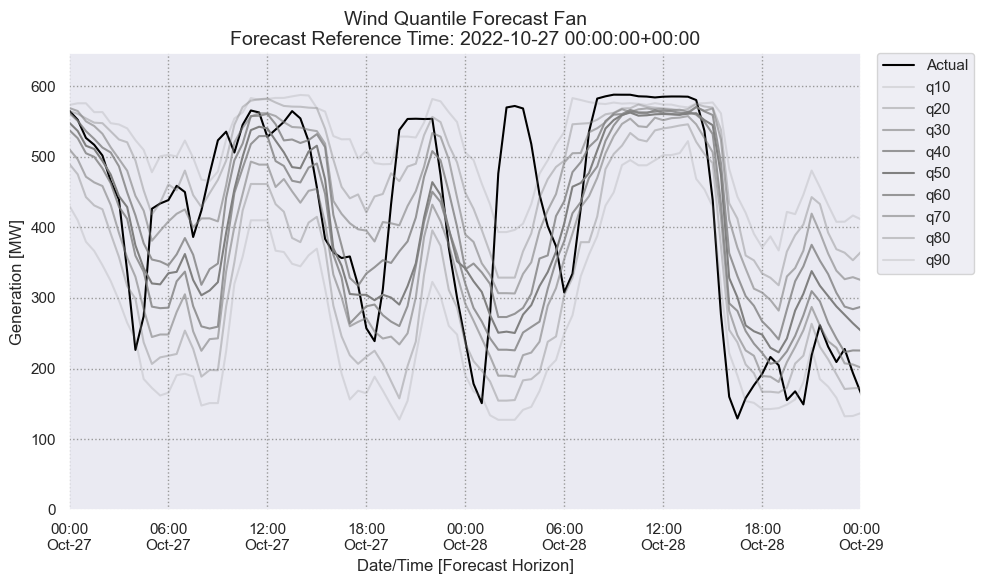

In [ ]:
# === FINAL QUANTILE MODEL TRAINING AND EVALUATION PLOTS ===


# === FIRST PART: DEFINE IMPORTANT FUNCTIONS ===

def train_final_quantile_models(X_train, y_train, quantiles):
    models = {}
    for q in quantiles:
        model = LGBMRegressor(objective='quantile', alpha=q, random_state=42, verbosity=-1)
        model.fit(X_train, y_train)
        models[q] = model
    return models

#def predict_all_quantiles(models, X):
#    return {q: model.predict(X) for q, model in models.items()}
def predict_all_quantiles(models, X):
    preds = {}
    for q, model in models.items():
        preds[q] = model.predict(X)  # 1D array, same order as X
    return preds

def calculate_pinball_loss(y_true, y_pred, alpha):
    return mean_pinball_loss(y_true, y_pred, alpha=alpha)

def plot_quantile_forecasts(datetime_index, actuals, predictions_dict, label="Model"):
    plt.figure(figsize=(15, 5))

    # Sort predictions by quantile
    sorted_qs = sorted(predictions_dict.keys())

    # Fill central prediction intervals
    for lower, upper in zip(sorted_qs[:len(sorted_qs)//2], reversed(sorted_qs[len(sorted_qs)//2+1:])):
        plt.fill_between(datetime_index,
                         predictions_dict[lower],
                         predictions_dict[upper],
                         alpha=0.2,
                         label=f"{int(lower*100)}–{int(upper*100)}% Interval")

    # Plot median
    plt.plot(datetime_index, predictions_dict[0.5], label="Predicted Median", color="blue")

    # Plot actuals
    plt.plot(datetime_index, actuals, label="Actual", color="black")

    plt.title(f"{label} Generation: Forecast vs Actual (Quantiles)")
    plt.xlabel("Datetime")
    plt.ylabel("Power (MWh)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# define the evaluating and plot function to use for both wind and solar
def plot_quantile_fan_chart(name, y_eval, preds, quantiles, eval_mask, modelling_table, ref_time_idx):
    # Extract datetime info
    ref_datetimes = modelling_table.loc[eval_mask, "ref_datetime"].reset_index(drop=True)
    valid_datetimes = modelling_table.loc[eval_mask, "valid_datetime"].reset_index(drop=True)
    chosen_ref_time = ref_datetimes.iloc[ref_time_idx]

    # Build DataFrame
    plot_df = pd.DataFrame({
        "ref_datetime": ref_datetimes,
        "valid_datetime": valid_datetimes,
        "actual": y_eval.reset_index(drop=True)
    })
    for q in quantiles:
        plot_df[f"q{int(q * 100)}"] = preds[q]

    plot_df = plot_df[plot_df["ref_datetime"] == chosen_ref_time].copy()

    # Set time window
    min_dt = plot_df["valid_datetime"].min()
    max_dt = plot_df["valid_datetime"].max()
    start_of_day = min_dt.replace(hour=0, minute=0, second=0, microsecond=0)
    end_of_day = start_of_day + pd.Timedelta(days=1)
    if max_dt > end_of_day:
        end_of_day += pd.Timedelta(days=1)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
    sns.lineplot(data=plot_df, x="valid_datetime", y="actual", label="Actual", color="black")

    for q in quantiles:
        label = f"q{int(q * 100)}"
        alpha = 1 - abs(0.5 - q) / 0.5
        sns.lineplot(data=plot_df, x="valid_datetime", y=label, color="gray", alpha=alpha, label=label)

    plt.ylim(0, plot_df.drop(columns=["ref_datetime", "valid_datetime"]).max().max() * 1.1)
    plt.xlim(start_of_day, end_of_day)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M\n%b-%d"))
    plt.xlabel('Date/Time [Forecast Horizon]')
    plt.ylabel('Generation [MW]')
    plt.title(f"{name} Quantile Forecast Fan\nForecast Reference Time: {chosen_ref_time}", fontsize=14)
    plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
    plt.tight_layout()
    plt.show()


def evaluate_and_plot(
    name, X_train, y_train, X_eval, y_eval,
    quantiles, eval_mask, modelling_table, ref_time_idx=370
):
    print(f"\n===== {name} Quantile Pinball Loss =====")

    # --- Train & Predict ---
    models = train_final_quantile_models(X_train, y_train, quantiles)
    preds = predict_all_quantiles(models, X_eval)

    # --- Pinball Loss ---
    quantile_losses = {
        q: calculate_pinball_loss(y_eval, preds[q], alpha=q)
        for q in quantiles
    }
    for q in quantiles:
        print(f"Quantile {int(q*100)}% Pinball Loss: {quantile_losses[q]:.4f}")

    avg_pinball = np.mean(list(quantile_losses.values()))
    normalized_pinball = avg_pinball / y_eval.mean()
    print(f"Average Pinball Loss (All Quantiles): {avg_pinball:.4f}")
    print(f"Normalized Pinball Loss: {normalized_pinball:.2%}")

    # --- Plot: Time-series forecast with prediction intervals ---
    plot_quantile_forecasts(modelling_table["valid_datetime"][eval_mask], y_eval, preds, label=name)

    # --- Plot: Fan chart for one forecast instance ---
    plot_quantile_fan_chart(name, y_eval, preds, quantiles, eval_mask, modelling_table, ref_time_idx)



# === SECOND PART: RUN FUNCTIONS ===

# --- Run for Solar and Wind ---
evaluate_and_plot("Solar", X_train_solar, y_train_solar, X_eval_solar, y_eval_solar, quantiles, eval_mask, modelling_table)
evaluate_and_plot("Wind", X_train_wind, y_train_wind, X_eval_wind, y_eval_wind, quantiles, eval_mask, modelling_table)


In [ ]:
# For one ref_datetime, how many timesteps long is the forecast for that ref_datetime?
# Basically, how many different valid_datetime is there for the same ref_datetime?
# Result: there is 4524 different ref_datetime and for each of them, the forecast is 100 timesteps long
# for 1 specific ref_datetime the forecast is only 96 timesteps long
# for 1 specific other ref_datetime the forecast is only 84 timesteps long
# and so on
mt_solar.groupby("ref_datetime")["valid_datetime"].count().value_counts()

valid_datetime
100    4524
96        1
84        1
72        1
60        1
48        1
Name: count, dtype: int64

In [ ]:
# def evaluate_and_plot(name, X_train, y_train, X_eval, y_eval, quantiles, eval_mask, modelling_table):
#     print(f"\n===== {name} Quantile Pinball Loss =====")
    
#     # Train and predict
#     models = train_final_quantile_models(X_train, y_train, quantiles)
#     preds = predict_all_quantiles(models, X_eval)
    
#     # Pinball losses
#     quantile_losses = {
#         q: calculate_pinball_loss(y_eval, preds[q], alpha=q)
#         for q in quantiles
#     }
#     for q in quantiles:
#         print(f"Quantile {int(q*100)}% Pinball Loss: {quantile_losses[q]:.4f}")
    
#     # Average and normalized
#     avg_pinball = np.mean(list(quantile_losses.values()))
#     normalized_pinball = avg_pinball / y_eval.mean()
#     print(f"Average Pinball Loss (All Quantiles): {avg_pinball:.4f}")
#     print(f"Normalized Pinball Loss: {normalized_pinball:.2%}")
    
#     # Plot
#     plot_quantile_forecasts(modelling_table["valid_datetime"][eval_mask], y_eval, preds, label=name)

# evaluate_and_plot("Solar", X_train_solar, y_train_solar, X_eval_solar, y_eval_solar, quantiles, eval_mask, modelling_table)
# evaluate_and_plot("Wind", X_train_wind, y_train_wind, X_eval_wind, y_eval_wind, quantiles, eval_mask, modelling_table)


# Step 1: Get evaluation reference and valid datetimes as Series aligned to y_eval_solar
# eval_ref_datetimes = mt_solar.loc[eval_mask, "ref_datetime"].reset_index(drop=True)
# eval_valid_datetimes = mt_solar.loc[eval_mask, "valid_datetime"].reset_index(drop=True)

# # Step 2: Choose a reference time from the evaluation set
# ref_time_idx = 370  # Change this index to pick a different forecast
# chosen_ref_time = eval_ref_datetimes.iloc[ref_time_idx]

# # Step 3: Build a full DataFrame containing all needed data
# plot_df = pd.DataFrame({
#     "ref_datetime": eval_ref_datetimes,
#     "valid_datetime": eval_valid_datetimes,
#     "actual": y_eval_solar.reset_index(drop=True)
# })

# # Step 4: Add each quantile's predictions
# for q in quantiles:
#     plot_df[f"q{int(q * 100)}"] = solar_preds[q]

# # Step 5: Filter rows for selected reference time
# plot_df = plot_df[plot_df["ref_datetime"] == chosen_ref_time].copy()

# # Step 6: Find start and end of plotting window
# min_valid_datetime = plot_df["valid_datetime"].min()
# max_valid_datetime = plot_df["valid_datetime"].max()

# start_of_day = min_valid_datetime.replace(hour=0, minute=0, second=0, microsecond=0)
# end_of_day = start_of_day + pd.Timedelta(days=1)

# if max_valid_datetime > end_of_day:
#     end_of_day = start_of_day + pd.Timedelta(days=2)

# # Step 7: Plot the fan chart
# plt.figure(figsize=(10, 6))
# sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

# # Actual observations
# sns.lineplot(data=plot_df, x="valid_datetime", y="actual", label="Actual", color="black")

# # Quantile forecasts
# for q in quantiles:
#     label = f"q{int(q * 100)}"
#     alpha = 1 - abs(0.5 - q) / 0.5
#     sns.lineplot(data=plot_df, x="valid_datetime", y=label, color="gray", alpha=alpha, label=label)

# # Format
# plt.ylim(0, plot_df.drop(columns=["ref_datetime", "valid_datetime"]).max().max() * 1.1)
# plt.xlim(start_of_day, end_of_day)
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M\n%b-%d"))
# plt.xlabel('Date/Time [Forecast Horizon]')
# plt.ylabel('Generation [MW]')
# plt.title(f"Quantile Forecast Fan\nForecast Reference Time: {chosen_ref_time}", fontsize=14)
# plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
# plt.tight_layout()
# plt.show()


# # Check the shape of the solar_preds array for each quantile
# for q in quantiles:
#     print(f"Prediction shape for q{int(q * 100)}: {solar_preds[q].shape}")

# print(f"Forecast horizon length for {chosen_ref_time}: {len(plot_df)} time steps")
# print(plot_df[["valid_datetime", "actual"]])